# Tarea 1 2025

Instrucciones

Su notebook con las respuestas a la tarea se deben entregar a mas tardar el dia 21/04/25 hasta las 21:00, subiendolo al repositorio en la carpeta tareas/2025.

Es importante considerar que el código debe poder ejecutarse en cualquier computadora con la data original del repositorio. Recordar la convencion para el nombre de archivo ademas de incluir en su documento titulos y encabezados por seccion. La data a utilizar es machine_failure_data.csv.

Las variables tienen la siguiente descripcion:

Date: data medida en frecuencia diaria
Location: ubicacion del medidor
Min_Temp: temperatura minima observada
Max_Temp: temperatura maxima observada
Leakage: Filtracion medida en el area
Evaporation: Tasa de evaporacion
Electricity: Consumo electrico KW
Parameter#: Diferentes sensores de reportando direccion y velocidad de viento en distintos momentos del dia, asi como otras metricas relevantes.
Failure today: El sensor reporta fallo (o no)

1. **Cargar la base de datos en el ambiente. Identifique los tipos de datos que se encuentran en la base, realice estadisticas descriptivas sobre las variables importantes (Hint: Revisar la distribuciones, datos faltantes, outliers, etc.) y limpie las variables cuando sea necesario.**

**R**: En resumen, se cargo la base datos, se renombro la data, se pasaron a binarias en caso de ser necesarias, transformamos dirreciones a Sen y Cos para estudiarlas de mejor manera, se eliminaron variables, y se eliminaron valores NaN luego de rellenar algunas variables con muchos datos NaN con su mediana, y finalizando varios histogramas de las variables y un mapa de calor de sus correlaciones. 

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
from scipy.stats import nbinom
import seaborn as sns
from statsmodels.iolib.summary2 import summary_col
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings("ignore")

%matplotlib inline

# Con esto podemos leer nuestra data
url="https://raw.githubusercontent.com/juancaros/LAB-MAA/refs/heads/main/data/machine_failure_data.csv"
df=pd.read_csv(url)

# Renombramos data
df=df.rename(columns={"Parameter1_Speed":"P1_Speed",
                     "Parameter1_Dir":"P1_Dir",
                      "Parameter2_3pm":"P2_3pm",
                     "Parameter2_9am":"P2_9am",
                     "Parameter3_9am":"P3_9am",
                     "Parameter3_3pm":"P3_3pm",
                    "Parameter4_9am":"P4_9am",
                    "Parameter4_3pm":"P4_3pm",
                    "Parameter5_9am":"P5_9am",
                    "Parameter5_3pm":"P5_3pm",
                    "Parameter6_9am":"P6_9am",
                    "Parameter6_3pm":"P6_3pm",
                    "Parameter7_9am":"P7_9am",
                    "Parameter7_3pm":"P7_3pm",
                    })

df['Failure']=df['Failure_today'].apply(lambda x:1 if x=='Yes' else 0)
df.drop('Failure_today', axis=1, inplace=True)

In [66]:
# Revisamos la correlacion entre estas variables para decidir si promediarlas o no 
param_pairs = [
    ('P3_9am', 'P3_3pm'),
    ('P4_9am', 'P4_3pm'),
    ('P5_9am', 'P5_3pm'),
    ('P6_9am', 'P6_3pm'),
    ('P7_9am', 'P7_3pm')
]

print("Correlaciones entre pares AM/PM:")
for am, pm in param_pairs:
    corr = df[[am, pm]].corr().iloc[0, 1]
    print(f"{am} y {pm}: {corr:.3f}")

Correlaciones entre pares AM/PM:
P3_9am y P3_3pm: 0.520
P4_9am y P4_3pm: 0.667
P5_9am y P5_3pm: 0.961
P6_9am y P6_3pm: 0.604
P7_9am y P7_3pm: 0.861


In [67]:
# Aca podemos observar que los pares P5 y P7, tienen una alta correlación por eso la promediamos 
df['P5'] = df[['P5_9am', 'P5_3pm']].mean(axis=1)
df['P7'] = df[['P7_9am', 'P7_3pm']].mean(axis=1)

# Botamos las columnas que no usaremos mas adelante
df.drop(columns=['P5_9am', 'P5_3pm', 'P7_9am', 'P7_3pm'], inplace=True)

# Transformamos direcciones a Grados para posteriormente trabajarlas como Sen y Cos
# Mapeo de direcciones a grados

dir_map = {
    'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
    'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
    'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
    'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
}

# Aplicamos la conversión a grados

df['P1_Dir'] = df['P1_Dir'].map(dir_map)
df['P2_9am'] = df['P2_9am'].map(dir_map)
df['P2_3pm'] = df['P2_3pm'].map(dir_map)

# Conversion a componentes circulares (Sen y Cos)

df['P1_Dir_sin'] = np.sin(np.radians(df['P1_Dir']))
df['P1_Dir_cos'] = np.cos(np.radians(df['P1_Dir']))

df['P2_9am_sin'] = np.sin(np.radians(df['P2_9am']))
df['P2_9am_cos'] = np.cos(np.radians(df['P2_9am']))

df['P2_3pm_sin'] = np.sin(np.radians(df['P2_3pm']))
df['P2_3pm_cos'] = np.cos(np.radians(df['P2_3pm']))

df = df.drop(['P1_Dir', 'P2_9am', 'P2_3pm'], axis=1)


# Reorganizar las columnas
cols = [ 
    'Date', 'Location', 'Min_Temp', 'Max_Temp', 'Leakage', 'Evaporation', 'Electricity', 
    'P1_Dir_sin', 'P1_Dir_cos', 'P1_Speed', 'P2_9am_sin', 'P2_9am_cos','P2_3pm_sin', 'P2_3pm_cos','P3_9am', 'P3_3pm', 'P4_9am', 'P4_3pm', 
    'P5', 'P6_9am', 'P6_3pm', 'P7', 'Failure'
]

# Aplicar el nuevo orden de columnas
df = df[cols]

In [68]:
# Revisamos y Calculamos el porcentaje de NaNs por columna
nan_percentage = df.isna().mean() * 100

# Mostrar el resultado ordenado de mayor a menor
print(nan_percentage.sort_values(ascending=False))

Electricity    47.692924
Evaporation    42.789026
P6_3pm         40.152469
P6_9am         37.735332
P5              9.698790
P2_9am_cos      7.041838
P2_9am_sin      7.041838
P1_Dir_sin      6.561504
P1_Dir_cos      6.561504
P1_Speed        6.519308
P2_3pm_sin      2.656952
P2_3pm_cos      2.656952
P4_3pm          2.538803
P3_3pm          1.849599
P4_9am          1.247600
Leakage         0.988797
P3_9am          0.948007
Min_Temp        0.447983
P7              0.248254
Max_Temp        0.226453
Date            0.000000
Location        0.000000
Failure         0.000000
dtype: float64


In [69]:
# Revisamos tambien correlaciones con variable Failure
numeric_df = df.select_dtypes(include=['number'])
correlations = numeric_df.corr()['Failure'].sort_values(ascending=False)
print(correlations)

Failure        1.000000
Leakage        0.500997
P4_3pm         0.375806
P4_9am         0.351251
P6_9am         0.303900
P6_3pm         0.270411
P1_Speed       0.153901
P3_9am         0.100975
P3_3pm         0.079155
Min_Temp       0.055743
Location      -0.004911
P2_9am_cos    -0.071456
P1_Dir_cos    -0.081838
P2_3pm_cos    -0.092079
P2_3pm_sin    -0.102339
P1_Dir_sin    -0.118267
P5            -0.148775
P7            -0.172466
P2_9am_sin    -0.175145
Evaporation   -0.187281
Max_Temp      -0.226715
Electricity   -0.328709
Name: Failure, dtype: float64


In [70]:
# Como p6 tiene un alto porcentaje de NaN y una correlación moderada, es posible asumir que no vale el estudio
# Esto no aplica para Electricity y Evaporation, dado que siento que aportan informacion importante a comparacion

df.drop(columns=['P6_9am','P6_3pm'], inplace=True)

# Calculamos el porcentaje de outliers para ver cómo proceder con el arreglo de valores NaN, sin eliminar información importante
outlier_counts = {}

for col in df.select_dtypes(include=['int64', 'float64']):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_counts[col] = len(outliers)

# Ordenamos de mayor a menor
outlier_counts = dict(sorted(outlier_counts.items(), key=lambda item: item[1], reverse=True))

# Imprimimos con formato ordenado
print(f"{'Columna':<25} {'% Outliers':>10}")
print("-" * 35)
for k, v in outlier_counts.items():
    percentage = (v / len(df)) * 100
    print(f"{k:<25} {percentage:>10.2f}")


Columna                   % Outliers
-----------------------------------
Failure                        22.12
Leakage                        17.74
P1_Speed                        2.11
P3_3pm                          1.73
Evaporation                     1.37
P3_9am                          1.22
P4_9am                          1.00
P5                              0.73
Max_Temp                        0.32
P7                              0.31
Min_Temp                        0.04
Location                        0.00
Electricity                     0.00
P1_Dir_sin                      0.00
P1_Dir_cos                      0.00
P2_9am_sin                      0.00
P2_9am_cos                      0.00
P2_3pm_sin                      0.00
P2_3pm_cos                      0.00
P4_3pm                          0.00


In [71]:
# Como observamos tenemos bajo porcentaje de outliers en Electricity y Evaporation, los cuales cuentan con una alta cantidad de NaN
# Debido a eso
df['Electricity'].fillna(df['Electricity'].median(), inplace=True)
df['Evaporation'].fillna(df['Evaporation'].median(), inplace=True)

# Luego eliminamos valores NaN restantes
df = df.dropna()

# Como Leakage cuenta con un alto porcentaje de outliers se pasa a logaritmica, para evitar problemas con el 0, usamos log1p para precision numerica
df['Leakage_log'] = np.log1p(df['Leakage']) 
df.drop(columns=['Leakage'], inplace=True)

df.describe()


,Location,Min_Temp,Max_Temp,Evaporation,Electricity,P1_Dir_sin,P1_Dir_cos,P1_Speed,P2_9am_sin,P2_9am_cos,P2_3pm_sin,P2_3pm_cos,P3_9am,P3_3pm,P4_9am,P4_3pm,P5,P7,Failure,Leakage_log
count,113046.000000,113046.000000,113046.000000,113046.000000,113046.000000,113046.000000,1.130460e+05,113046.000000,1.130460e+05,1.130460e+05,113046.000000,1.130460e+05,113046.000000,113046.000000,113046.000000,113046.000000,113046.000000,113046.000000,113046.000000,113046.000000
mean,24.942988,12.665000,23.653735,5.304013,8.043634,-0.013110,-5.765815e-02,40.790245,3.700453e-02,2.822362e-03,-0.014776,-5.668781e-02,15.181492,19.503476,67.407719,50.676689,1016.237140,19.793246,0.224891,0.487395
std,14.456579,6.252988,6.981747,3.376396,2.925711,0.712834,6.988420e-01,13.322060,6.916913e-01,7.212453e-01,0.709785,7.019843e-01,8.345033,8.582582,18.910860,20.770150,6.925093,6.360144,0.417512,0.908222
min,1.000000,-8.200000,2.600000,0.000000,0.000000,-1.000000,-1.000000e+00,7.000000,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000e+00,2.000000,2.000000,0.000000,0.000000,979.750000,1.250000,0.000000,0.000000
25%,12.000000,8.100000,18.300000,4.000000,7.700000,-0.707107,-7.071068e-01,31.000000,-7.071068e-01,-7.071068e-01,-0.707107,-7.071068e-01,9.000000,13.000000,56.000000,36.000000,1011.550000,14.950000,0.000000,0.000000
50%,23.000000,12.400000,23.100000,4.800000,8.500000,0.000000,-1.836970e-16,39.000000,1.224647e-16,6.123234e-17,0.000000,-1.836970e-16,13.000000,19.000000,68.000000,51.000000,1016.200000,19.400000,0.000000,0.000000
75%,38.000000,17.200000,28.700000,6.000000,9.400000,0.707107,7.071068e-01,48.000000,7.071068e-01,7.071068e-01,0.707107,7.071068e-01,20.000000,24.000000,81.000000,65.000000,1020.850000,24.350000,0.000000,0.587787
max,49.000000,33.900000,48.100000,82.400000,14.500000,1.000000,1.000000e+00,135.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,87.000000,87.000000,100.000000,100.000000,1040.050000,41.600000,1.000000,5.909712


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113046 entries, 0 to 142192
Data columns (total 21 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Date         113046 non-null  object 
 1   Location     113046 non-null  int64  
 2   Min_Temp     113046 non-null  float64
 3   Max_Temp     113046 non-null  float64
 4   Evaporation  113046 non-null  float64
 5   Electricity  113046 non-null  float64
 6   P1_Dir_sin   113046 non-null  float64
 7   P1_Dir_cos   113046 non-null  float64
 8   P1_Speed     113046 non-null  float64
 9   P2_9am_sin   113046 non-null  float64
 10  P2_9am_cos   113046 non-null  float64
 11  P2_3pm_sin   113046 non-null  float64
 12  P2_3pm_cos   113046 non-null  float64
 13  P3_9am       113046 non-null  float64
 14  P3_3pm       113046 non-null  float64
 15  P4_9am       113046 non-null  float64
 16  P4_3pm       113046 non-null  float64
 17  P5           113046 non-null  float64
 18  P7           113046 non-null 

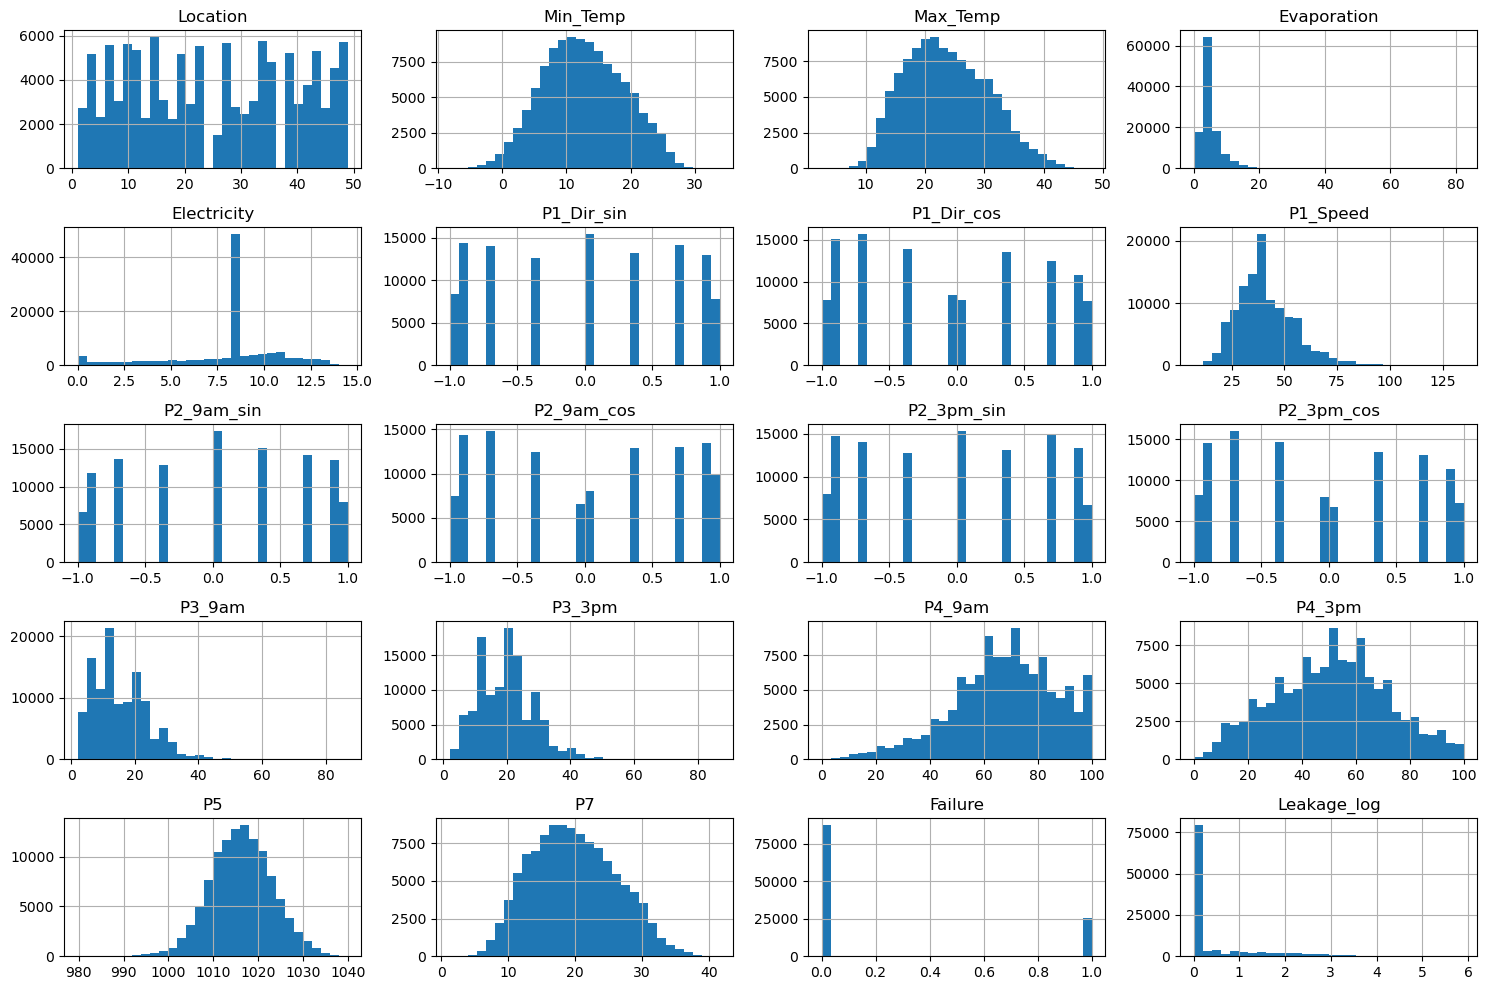

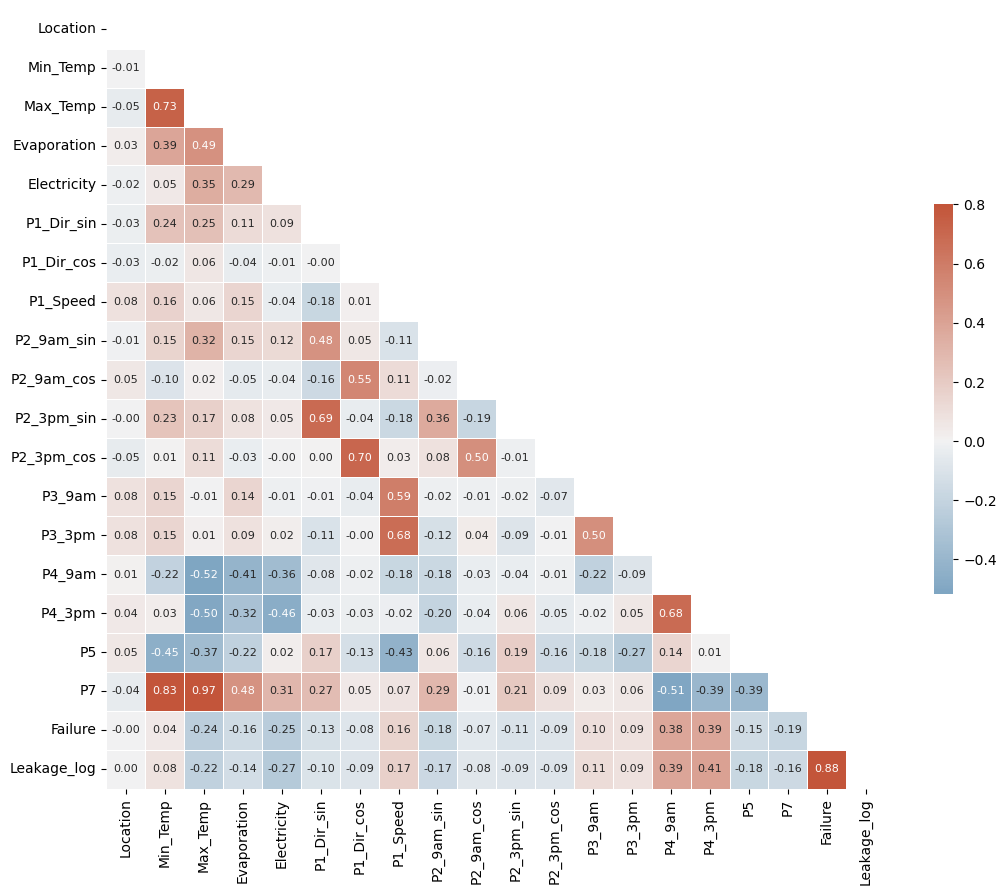

In [73]:
# Creamos visualizacion de histograma y de mapa de calor de correlaciones

df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

corr = df.select_dtypes(include=['number']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(240, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True, fmt=".2f", annot_kws={"size": 8})

plt.tight_layout()
plt.show()

# MCO 

2. **Ejecute un modelo de probabilidad lineal (MCO) que permita explicar la probabilidad de que un dia se reporte fallo medido por sensor, a partir de las informacion disponible. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.**

**R:** Segun el modelo, excluyendo las variables que no contribuyen dada alta correlacion, encontramos que el 27.2% del fallo del sensor por día es explicado por los datos, tambien podemos observar como el aumento de temperatura maxima indica que se reducen las probabilidades de fallo, lo que puede indicar que a una menor humedad funciona mejor el sensor, lo que se explica tambien con que a mayor evaporacion (osea mayor temperatura), se podrian prevenir cortocircuitos, corrosion o algun otro fallo que produsca fallo en el sensor. Los resultados son interpretados como cambios en puntos porcentuales por cambio de una unidad en la variable. 
   

In [74]:
# Debido a la alta correlacion explicativa de Leakage (0.88) sobre Failure se decide eliminar
df.drop(columns=['Leakage_log'], inplace=True)

# Tambien se decide eliminar P7 por su alta correlacion con otras variables
df.drop(columns=['P7'], inplace=True)

# Estandarizamos variables continuas para proceder con modelos explicativos
X = df.drop(['Failure','Date','P1_Dir_sin','P1_Dir_cos','P2_9am_sin','P2_9am_cos','P2_3pm_sin','P2_3pm_cos','Location'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

direction_cols = ['P1_Dir_sin', 'P1_Dir_cos', 'P2_9am_sin', 'P2_9am_cos', 'P2_3pm_sin', 'P2_3pm_cos','Location']
directions = df[direction_cols]

X_final = pd.concat([X_scaled, directions], axis=1)

# Pasamos variable location a categorica
X_final['Location'] = X_final['Location'].astype('category')

# Agregamos constante (intercepto)
X_final = sm.add_constant(X_final)
y = df['Failure']

# Ajustamos el modelo OLS
model = sm.OLS(y, X_final)
results = model.fit(cov_type='HC0')
 
# Mostramos resumen
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Failure   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     2526.
Date:                Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:29:06   Log-Likelihood:                -43759.
No. Observations:              113046   AIC:                         8.755e+04
Df Residuals:                  113028   BIC:                         8.773e+04
Df Model:                          17                                         
Covariance Type:                  HC0                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2370      0.002    111.419      

# Probit

3. **Ejecute un modelo probit para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.**

**R:** Podemos observar como los impactos de un aumento de temperatura maxima, y de evaporacion explican la reduccion aun mas de un fallo de sensor ese dia, en cuanto a los efectos marginales podemos asociarlo como que, un cambio de una unidad en la variable, manteniendo el resto constantes, produce un cambio de x puntos porcentuales en que varie la probabilidad de fallo, en promedio.  

Algunas variables dejan de ser explicativas tales como las direcciones P1. esto se puede comprobar de mejor manera en un modelo probit, gracias a sus efectos marginales.  

In [75]:
# Ajustamos para el modelo Probit
model_probit = sm.Probit(y, X_final)
probit_model = model_probit.fit(cov_type='HC0')

# Mostramos el resumen del modelo
print(probit_model.summary())

# Efectos marginales del modelo
mfxp = probit_model.get_margeff()
print(mfxp.summary())

Optimization terminated successfully.
         Current function value: 0.367175
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:                Failure   No. Observations:               113046
Model:                         Probit   Df Residuals:                   113028
Method:                           MLE   Df Model:                           17
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.3112
Time:                        23:29:09   Log-Likelihood:                -41508.
converged:                       True   LL-Null:                       -60257.
Covariance Type:                  HC0   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.0946      0.011    -97.760      0.000      -1.117      -1.073
Min_Temp        0.6778    

# Logit

4. **Ejecute un modelo logit para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.**

**R:**  Aca agregamos la razon de probabilidad que indica como se multiplica el riesgo por cada unidad de cambio, ya que sucede que igual que el probit, los coeficientes de logit no son directamente interpretables en terminos de probabilidad.

Por ejemplo, interpretando los Odd ratios tenemos que:

si Odd ratio > 1: Aumento del riesgo
   Odd ratio < 1: Reducción del riesgo

In [76]:
# Ajustamos el modelo
model_logit = sm.Logit(y, X_final)
logit_model = model_logit.fit(cov_type='HC0')

# Mostramos el resumen del modelo
print(logit_model.summary())

# Efectos marginales del modelo
mfx_logit = logit_model.get_margeff()
print(mfx_logit.summary())

params = logit_model.params
conf = logit_model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['Odds Ratio', '5%', '95%']
print("Odds Ratios")
print(np.exp(conf).iloc[1:17 , ])

Optimization terminated successfully.
         Current function value: 0.365954
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Failure   No. Observations:               113046
Model:                          Logit   Df Residuals:                   113028
Method:                           MLE   Df Model:                           17
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.3134
Time:                        23:29:10   Log-Likelihood:                -41370.
converged:                       True   LL-Null:                       -60257.
Covariance Type:                  HC0   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.9491      0.020    -96.816      0.000      -1.989      -1.910
Min_Temp        1.2448    

# Resultados

5. **Comente los resultados obtenidos en 2, 3 y 4. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?**

**R:** Existen diferencias tales como, subestimacion de los efectos por parte del MCO, pero tambien tiene como ventaja una interpretacion más directa pero que puede incluir más errores, que a diferencia del probit y el logit no tienen. Estas 2 ultimas mencionadas tienen varias similitudes, tales como el uso de funciones no lineales y a su vez la generacion de efectos marginales comparables, entre estas tambien difieren en sus magnitudes dado que logit tambien usa los Odds ratios explicados anteriormente.

El más adecuado sería el logit, gracias a su posibilidad de interpretación, debido a los odd ratios que permiten comunicar el riesgo en terminos mucho mas intuitivos, su flexibilidad, dado que funciona mejor con la variable binaria Failure, y por ultimo la consistencia al tener las mismas herramientas en cuanto a efectos marginales, pero más extendidas. 

Y en cuanto a las variables más robustas a la especificación tenemos a: 

Max_temp: que tiene una interpretacion de robustez que reduce el riesgo si la temperatura es aumentada.
Evaporation: que tiene la misma interpretacion de reducir el riesgo si es aumentada.
Min_Temp: tambien observamos que una disminución en las temperaturas podria provocar fallas, lo que indica que el sensor no soporta temperaturas frias.

Y algunas que resultaron ser menos robustas fueron las direcciones, y electricity. 

# Poisson

6. **Agregue la data a nivel mensual, usando la data promedio de las variables (ignorando aquellas categoricas, como la direccion del viento). En particular, genere una variable que cuente la cantidad de fallos observados en un mes, utilice un valor de 0 si en ese mes no se reporto fallos en ningun dia. Use un modelo Poisson para explicar el numero de fallas por mes. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.**

**R:** Como observamos hay sobredispersion, ya que la desviacion / grados de libertad es mayor que 1, recayendo en pseudo r cuadrado = 1, es decir, la variabilidad en los datos es mucho mayor que la esperada bajo un modelo Poisson puro. Este exceso de varianza puede inflar los errores estándar de los coeficientes, afectando la confiabilidad de las pruebas de significancia. Además, el valor del pseudo R-cuadrado igual a 1 no necesariamente implica un ajuste perfecto, sino que puede ser consecuencia directa de esta sobredispersión.

In [77]:
# Agregamos columna de mes (Año-Mes)
df['Date'] = pd.to_datetime(df['Date'])
df['YearMonth'] = df['Date'].dt.to_period('M')

# Variables numéricas (excluyendo las categóricas como Location)
numeric_vars = df.select_dtypes(include='number').columns.tolist()
numeric_vars.remove('Failure')  # Excluir la variable objetivo

# Lista de columnas de dirección a excluir
dir_cols = ['Location', 'P1_Dir_sin', 'P1_Dir_cos', 'P2_9am_sin', 'P2_9am_cos', 'P2_3pm_sin', 'P2_3pm_cos']

# Filtramos para quedarnos solo con las variables numéricas que NO son de dirección
numeric_vars = [var for var in numeric_vars if var not in dir_cols]

# Agrupamos por mes y calculamos promedios mensuales (excluyendo columnas de dirección)
monthly_avg = df.groupby('YearMonth')[numeric_vars].mean()

# Contamos cantidad de fallos por mes
monthly_failures = df.groupby('YearMonth')['Failure'].sum()

# Unimos ambas partes
monthly_data = monthly_avg.copy()
monthly_data['Failures_in_month'] = monthly_failures
monthly_data['Failures_in_month'] = monthly_data['Failures_in_month'].fillna(0).astype(int)

# Variable dependiente
y = monthly_data['Failures_in_month']

# Variables independientes (sin las columnas de dirección y ubicacion)
X = monthly_data.drop(columns=['Failures_in_month'])

# Agregamos constante
X = sm.add_constant(X)

# Modelo Poisson
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      Failures_in_month   No. Observations:                  113
Model:                            GLM   Df Residuals:                      102
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1019.3
Date:                Thu, 24 Apr 2025   Deviance:                       1249.4
Time:                        23:29:15   Pearson chi2:                 1.12e+03
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.5361      4.602      2.072      

# Dispersion y Alpha

7. **Determine sobre dispersion en la data y posible valor optimo de alpha para un modelo Binomial Negativa.**

**R:** Cuando nuestra varianza observada es significativamente mayor que la media (lo cual es el caso aquí, con desviacion / grados de libertad        ≈ 12.25), se considera que hay sobredispersión.

El histograma presentado muestra una distribución amplia y asimétrica de los valores esperados de λ (tasas esperadas de fallos por mes). Esto sugiere una alta variabilidad entre los meses, lo cual es otra señal de que la suposición de varianza igual a la media (Poisson) podría no ser realista.

Encontramos un posible valor optimo para un modelo Binomial Negativo de 1.03


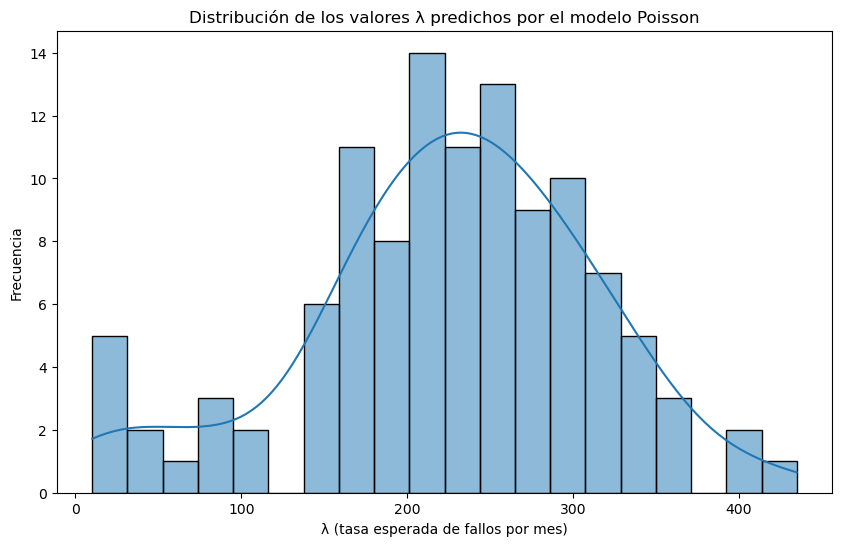

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.181
Model:                            OLS   Adj. R-squared (uncentered):              0.174
Method:                 Least Squares   F-statistic:                              24.80
Date:                Thu, 24 Apr 2025   Prob (F-statistic):                    2.33e-06
Time:                        23:29:17   Log-Likelihood:                         -464.16
No. Observations:                 113   AIC:                                      930.3
Df Residuals:                     112   BIC:                                      933.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [78]:
# Obtenemos las predicciones lambda (μ) del modelo
monthly_data['plambda'] = poisson_model.mu

# Graficamos el histograma de las lambdas predichas
plt.figure(figsize=(10, 6))
sns.histplot(data=monthly_data, x="plambda", bins=20, kde=True)
plt.title('Distribución de los valores λ predichos por el modelo Poisson')
plt.xlabel('λ (tasa esperada de fallos por mes)')
plt.ylabel('Frecuencia')
plt.show()

# Calculamos alpha estimado
predictions = poisson_model.predict(X)  

# Calculamos la variable auxiliar para estimar alpha
aux = ((monthly_data['Failures_in_month'] - predictions)**2 - predictions) / predictions
aux_model = sm.OLS(aux, predictions).fit()
print(aux_model.summary())

# El coeficiente estimado es una aproximación de ln(alpha)
coef_aux = aux_model.params[0]
print(f"\nCoeficiente de la regresión auxiliar: {coef_aux:.4f}")

# Estimación de alpha (ajustada según metodología)
alpha_estimado = np.exp(coef_aux)  # Exponencial del coeficiente

print(f"Alpha estimado (exp(coef)): {alpha_estimado:.4f}")


# Binomial Negativa

8. **Usando la informacion anterior, ejecute un modelo Binomial Negativa para responder a la pregunta 6. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.**

**R:** Los resultados del modelo Binonial Negativa, con el valor de alpha sugerido en la regresion auxiliar, entrega un ajuste mucho más realista respecto del modelo Poisson basado en el valor del r-cuadrado.


In [79]:
# Ajustamos el modelo Binomial Negativo

alpha_initial = 1.03
negbin_model = sm.GLM(
    y, 
    X, 
    family=sm.families.NegativeBinomial(alpha=alpha_initial)
).fit()

print(negbin_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:      Failures_in_month   No. Observations:                  113
Model:                            GLM   Df Residuals:                      102
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -703.58
Date:                Thu, 24 Apr 2025   Deviance:                       12.832
Time:                        23:29:21   Pearson chi2:                     10.4
No. Iterations:                    18   Pseudo R-squ. (CS):             0.3313
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -20.6833     66.552     -0.311      

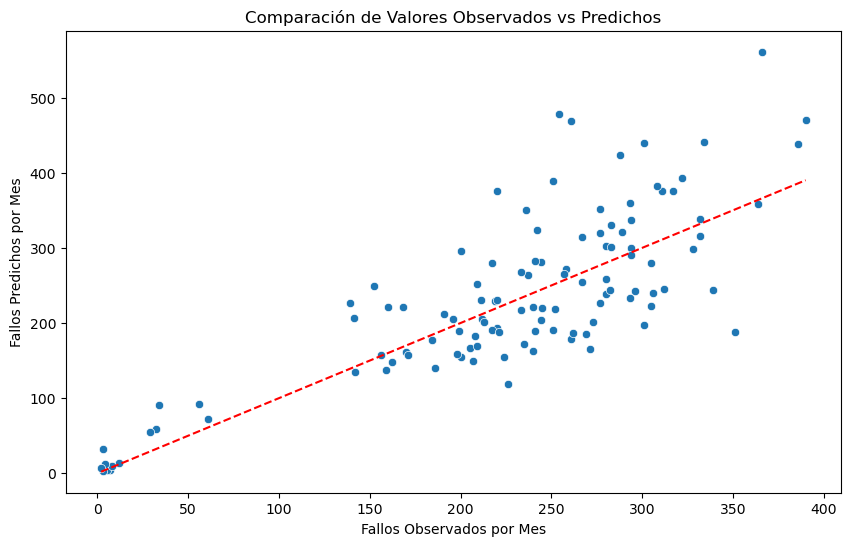

In [80]:
# Comparacion de Valores Observados vs Predichos

negbin = sm.GLM(y, X, family=sm.families.NegativeBinomial(alpha=1.03)).fit()

# Agregamos las predicciones a tu dataframe mensual
monthly_data['ypred'] = negbin.predict(X)  # X ya incluye la constante

# Creamos el gráfico de valores observados vs predichos
plt.figure(figsize=(10, 6))
sns.scatterplot(data=monthly_data, x='Failures_in_month', y='ypred')
plt.plot([monthly_data['Failures_in_month'].min(), monthly_data['Failures_in_month'].max()], 
         [monthly_data['Failures_in_month'].min(), monthly_data['Failures_in_month'].max()], 
         'r--')  # Línea de 45 grados
plt.xlabel('Fallos Observados por Mes')
plt.ylabel('Fallos Predichos por Mes')
plt.title('Comparación de Valores Observados vs Predichos')
plt.show()

# Resultados

9. **Comente los resultados obtenidos en 6, 7 y 8. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?**

**R:** En general en el modelo de poisson, se asume que la varianza es igual a la media. El pseudo R-cuadrado fue 1, lo que sugiere un ajuste aparentemente perfecto. Sin embargo, se observó un valor de deviance/d.f. ≈ 12.25, lo que evidencia una alta sobredispersión.

Se mostró que la tasa esperada de fallas por mes (λ) presentaba una alta dispersión y asimetría. Esto refuerza visualmente la sobredispersión en los datos, dando más soporte a la necesidad de un modelo que la contemple, como el Binomial Negativo.

Existen varias diferencias entre ambos modelos, como que el pseudo R cuadrado es más realista en el modelo binomial negativo, lo que suguiere que las variables no se encuentran infladas y que son más conservadoras respecto a Failure, esto también es un indicio de variables más robustas en este modelo.

Es por eso que el modelo Binomial Negativa es claramente más adecuado, dado que corrige la dispersión, tambien proporciona errores estándar más realistas y por ultimo, su ajuste refleja mejor variabilidad de los datos. 

Algunas variables que mantuvieron su efecto consistente fueron electricity y ambos P3, lo que demostró su robustez. Y en cuanto a algunas variables que se vieron más inestables vimos a la temperatura minima y maxima, y evaporacion, variando un poco su impacto al cambiar de especificación, estas ultimas afirmaciones pueden deberse al sobreajuste e inflacion que provocaba el modelo Poisson. 
